# Crowdsourcing Medical Image Evaluation

Interpreting and correctly classifying medical images of all sorts is an important but expensive task, requiring the time of highly trained specialists. Could this process be made more efficient with crowdsourcing technology? In this report, we will take a first-pass look at analyzing the results of an attempt to do just that. 

We will work with a dataset of 30,000 records of medical image classifications. These records will include the judgments of a panel of 8 experts, and also the judgments of a varying number of people who are associated with the medical field, but not necessarily experts in the subject matter - this latter being our 'crowdsource' group. The crowdsourced judgments were gathered via an app available to people who work in medical professions or are students in medical school.

In [109]:
import pandas as pd
import numpy as np
import re

In [110]:
results = pd.read_csv('label-medical-images/centaur-data/1345_customer_results.csv')
results.head()

,Case ID,Origin,Origin Created At,Content ID,URL,Labeling State,Series,Series Index,Patch,Qualified Reads,...,Agreement,First Choice Answer,First Choice Votes,First Choice Weight,Second Choice Answer,Second Choice Votes,Second Choice Weight,Internal Notes,Comments,Explanation
0,5888087,https://centaur-customer-uploads.s3.us-east-1....,Jul 26 2021 21:41:47 PM,3264386,https://go.centaurlabs.com/problem/5888087,Gold Standard,NaN,NaN,NaN,2,...,1.000,'no',2,1.54,'yes',0,0.00,NaN,[],NaN
1,5888088,https://centaur-customer-uploads.s3.us-east-1....,Jul 26 2021 21:41:47 PM,3264387,https://go.centaurlabs.com/problem/5888088,Gold Standard,NaN,NaN,NaN,3,...,1.000,'no',3,2.34,'yes',0,0.00,NaN,[],NaN
2,5888089,https://centaur-customer-uploads.s3.us-east-1....,Jul 26 2021 21:41:47 PM,3264388,https://go.centaurlabs.com/problem/5888089,Gold Standard,NaN,NaN,NaN,2,...,1.000,'no',2,1.70,'yes',0,0.00,NaN,[],NaN
3,5888090,https://centaur-customer-uploads.s3.us-east-1....,Jul 26 2021 21:41:47 PM,3264389,https://go.centaurlabs.com/problem/5888090,Gold Standard,NaN,NaN,NaN,1,...,1.000,'no',1,0.82,'yes',0,0.00,NaN,[],NaN
4,5888091,https://centaur-customer-uploads.s3.us-east-1....,Jul 26 2021 21:41:47 PM,3264390,https://go.centaurlabs.com/problem/5888091,In Progress,NaN,NaN,NaN,7,...,0.571,'yes',4,3.28,'no',3,2.32,NaN,[],NaN


In [111]:
results.shape

(30293, 23)

Here we see a few rows of the dataset. 

The task for analysis will entail using this data to compare the accuracy of expert judgments on these images against the accuracy of the crowdsourced judgments, and attempting to determine at least in a first-pass way whether there may be merit in the crowdsourcing approach.

<b>Section I</b> will be concerned with the details of data cleaning: pulling out the quantitative data that we may want to use, and making sure it's in convenient form for future calculations.

<b>Section II</b> will be concerned with the analysis: comparing expert accuracy against crowd accuracy, over most of these cases. There will also be a subsection looking into how we might judge the crowdsourcing performance in those cases where we don't have an expert majority judgment to provide a baseline for what to consider as correct.

---

<h2>I. Data Cleaning</h2>

The first step in finding insights from this data will be extracting from it only the quantitative information that we need. This section will show how that work was done. (Skip ahead to section II if you want to go straight to the analysis.)

---

<h3>Extracting the Expert Vote Numbers</h3>

One critical piece of information we need is buried: the number of expert judgments on each case are within the URL strings in the "Origin" column. We'll begin by extracting those numbers, and along the way also discard the rows where there is no such number to work with.

In [112]:
sample_url = results.loc[0, 'Origin']
sample_url

'https://centaur-customer-uploads.s3.us-east-1.amazonaws.com/mgh-eeg/210721/jpg/B14_time139137_medoid_vote2.jpg'

The number found after the word 'vote' near the ends of the 'Origin' URL strings is the number of expert 'yes' votes, from a panel of 8 experts. 'Yes' votes here mean that the medical image in question was judged as abnormal.

We can slice from the ends of those strings to see these vote numbers more clearly:

In [113]:
vote_strings = results['Origin'].apply(lambda x: x[-9::1])
vote_strings

0        vote2.jpg
1        vote0.jpg
2        vote0.jpg
3        vote0.jpg
4        vote4.jpg
           ...    
30288    vote2.jpg
30289    vote3.jpg
30290    vote4.jpg
30291    vote5.jpg
30292    vote5.jpg
Name: Origin, Length: 30293, dtype: object

Some of the records don't have this expert vote number, and those are not useful for our analysis, so we'll want to drop them. We can find the ones that do have the string we want with a regular expression, 'vote[0-8]'. Then we'll able to select for only those rows. This will reduce the dataset to 27,000 rows:

In [114]:
voteN_found = results['Origin'].apply(lambda x: re.search('vote[0-8]', x))
results_trimmed = results[voteN_found.apply(pd.notna)]
results_trimmed.shape

(27000, 23)

Now we'll extract the expert yes vote numbers alone, and insert them as a new column into the dataframe:

In [115]:
expert_yes_votes = results_trimmed['Origin'].apply(lambda x: re.search('vote[0-8]', x).group()[-1])
results_trimmed.insert(1, 'Expert Yes Votes', expert_yes_votes)
results_trimmed.head()

,Case ID,Expert Yes Votes,Origin,Origin Created At,Content ID,URL,Labeling State,Series,Series Index,Patch,...,Agreement,First Choice Answer,First Choice Votes,First Choice Weight,Second Choice Answer,Second Choice Votes,Second Choice Weight,Internal Notes,Comments,Explanation
0,5888087,2,https://centaur-customer-uploads.s3.us-east-1....,Jul 26 2021 21:41:47 PM,3264386,https://go.centaurlabs.com/problem/5888087,Gold Standard,NaN,NaN,NaN,...,1.000,'no',2,1.54,'yes',0,0.00,NaN,[],NaN
1,5888088,0,https://centaur-customer-uploads.s3.us-east-1....,Jul 26 2021 21:41:47 PM,3264387,https://go.centaurlabs.com/problem/5888088,Gold Standard,NaN,NaN,NaN,...,1.000,'no',3,2.34,'yes',0,0.00,NaN,[],NaN
2,5888089,0,https://centaur-customer-uploads.s3.us-east-1....,Jul 26 2021 21:41:47 PM,3264388,https://go.centaurlabs.com/problem/5888089,Gold Standard,NaN,NaN,NaN,...,1.000,'no',2,1.70,'yes',0,0.00,NaN,[],NaN
3,5888090,0,https://centaur-customer-uploads.s3.us-east-1....,Jul 26 2021 21:41:47 PM,3264389,https://go.centaurlabs.com/problem/5888090,Gold Standard,NaN,NaN,NaN,...,1.000,'no',1,0.82,'yes',0,0.00,NaN,[],NaN
4,5888091,4,https://centaur-customer-uploads.s3.us-east-1....,Jul 26 2021 21:41:47 PM,3264390,https://go.centaurlabs.com/problem/5888091,In Progress,NaN,NaN,NaN,...,0.571,'yes',4,3.28,'no',3,2.32,NaN,[],NaN


### Selecting for Quantitative Data Only

Now we'll trim the table down much more.

The columns to be kept will be only the Case ID and the quantitative columns that relate to classification votes and accuracy.

We will be dropping many columns in the next cell below, for the following reasons:

- Origin: Having extracted the expert vote numbers, these URLs are of no further relevance for analysis.
- Origin Created At: Exactly when this data was created is not relevant for analyzing the labelling accuracy we're interested in.
- Content ID: The exact media type of the content in a specific case is not relevant for analyzing the labelling accuracy.
- URL: This is a reference to the case in Centaur's system. Not relevant for anayzing labelling accuracy.
- Labelling State: This is not quantitative data pertaining to labelling accuracy.
- Series, Series Index, and Patch: These all pertain to identifying the exact content used in a specific case. Not relevant for analyzing labelling accuracy.
- Internal Notes, Comments, Explanation: None of these are quantitative information about the labelling accuracy.
- voteN found: This was a column I had added temporarily just as an aid in data cleaning. It isn't needed anymore.



In [116]:
results_quant = results_trimmed.loc[:, 'Qualified Reads':'Second Choice Weight' ]
results_quant.insert(0, 'Expert Yes Votes', results_trimmed['Expert Yes Votes'])
results_quant.insert(0, 'Case ID', results_trimmed['Case ID'])
results_quant

,Case ID,Expert Yes Votes,Qualified Reads,Correct Label,Majority Label,Difficulty,Agreement,First Choice Answer,First Choice Votes,First Choice Weight,Second Choice Answer,Second Choice Votes,Second Choice Weight
0,5888087,2,2,'no','no',0.000,1.000,'no',2,1.54,'yes',0,0.00
1,5888088,0,3,'no','no',0.000,1.000,'no',3,2.34,'yes',0,0.00
2,5888089,0,2,'no','no',0.000,1.000,'no',2,1.70,'yes',0,0.00
3,5888090,0,1,'no','no',0.000,1.000,'no',1,0.82,'yes',0,0.00
4,5888091,4,7,NaN,'yes',NaN,0.571,'yes',4,3.28,'no',3,2.32
...,...,...,...,...,...,...,...,...,...,...,...,...,...
30288,5918375,2,2,'no','yes',1.000,1.000,'yes',2,1.56,'no',0,0.00
30289,5918376,3,3,'no','yes',0.667,0.667,'yes',2,1.56,'no',1,0.76
30290,5918377,4,6,NaN,'yes',NaN,1.000,'yes',6,4.78,'no',0,0.00
30291,5918378,5,0,'yes',NaN,NaN,NaN,'yes',0,0.00,'no',0,0.00


### Data Types and Ease of Use Adjustments

For ease of later working with this data, let's check that the data types of these columns are sensible:

In [117]:
results_quant.dtypes

Case ID                   int64
Expert Yes Votes         object
Qualified Reads           int64
Correct Label            object
Majority Label           object
Difficulty              float64
Agreement               float64
First Choice Answer      object
First Choice Votes        int64
First Choice Weight     float64
Second Choice Answer     object
Second Choice Votes       int64
Second Choice Weight    float64
dtype: object

The 'Expert Yes Votes' column is of object type, since we extracted those numbers from strings, but we'll want that to be a numeric type to calculate with later:

In [118]:
results_quant['Expert Yes Votes'] = results_quant['Expert Yes Votes'].apply(pd.to_numeric)
results_quant['Expert Yes Votes'].dtype

dtype('int64')

Also for ease of later use, let's get rid of the extraneous single-quote marks around all the 'yes' and 'no' answers in the data:

In [119]:
def remove_single_quotes(s):
    if type(s) == str:
        return s.strip("'")

In [120]:
text_col_names = ['Correct Label', 'Majority Label', 'First Choice Answer', 'Second Choice Answer']
for col in text_col_names:
    results_quant[col] = results_quant[col].apply(remove_single_quotes)
    
results_quant

,Case ID,Expert Yes Votes,Qualified Reads,Correct Label,Majority Label,Difficulty,Agreement,First Choice Answer,First Choice Votes,First Choice Weight,Second Choice Answer,Second Choice Votes,Second Choice Weight
0,5888087,2,2,no,no,0.000,1.000,no,2,1.54,yes,0,0.00
1,5888088,0,3,no,no,0.000,1.000,no,3,2.34,yes,0,0.00
2,5888089,0,2,no,no,0.000,1.000,no,2,1.70,yes,0,0.00
3,5888090,0,1,no,no,0.000,1.000,no,1,0.82,yes,0,0.00
4,5888091,4,7,None,yes,NaN,0.571,yes,4,3.28,no,3,2.32
...,...,...,...,...,...,...,...,...,...,...,...,...,...
30288,5918375,2,2,no,yes,1.000,1.000,yes,2,1.56,no,0,0.00
30289,5918376,3,3,no,yes,0.667,0.667,yes,2,1.56,no,1,0.76
30290,5918377,4,6,None,yes,NaN,1.000,yes,6,4.78,no,0,0.00
30291,5918378,5,0,yes,None,NaN,NaN,yes,0,0.00,no,0,0.00


### Cleaned Dataframe

Now the strings are easy to handle, numbers are appropriate number types, and we've selected for a dataframe of only quantitative data to explore and analyze.

In [121]:
len(results_quant[ results_quant['Correct Label'] == 'yes' ])

12000

In [122]:
len(results_quant[ results_quant['Correct Label'] == 'no' ])

12000

In [123]:
len(results_quant[ results_quant['Correct Label'].apply(pd.isna) ])

3000

We can see here that we will have a remarkably neat set of data to work with at this point. It contains exactly 12,000 cases where the expert vote favored 'yes' there was an abnormality in the image, another 12,000 where the expert vote favored 'no' to indicate a normal healthy image, and 3,000 where the expert vote was split (i.e., there is no 'correct label').

---

## II. Analysis: Comparing Expert Accuracy Against Crowd Accuracy

The approach for this analysis will be to calculate an accuracy rating for the experts, an accuracy rating for the crowd, and compare the two to get a sense of how well the crowd did.

In the dataset, the cases where the 8 expert judgments obtained a majority opinion will serve as the baseline for judging how accurate the crowdsourced opinions are. This corresponds to the 'Correct Label' column in the dataset: a correct label of 'yes' means at least 5 out of 8 experts voted 'yes' for that image, a correct label of 'no' means at least 5 out of 8 experts voted 'no' for that image, and where there is no correct label, the expert vote was a tie.

As for the crowdsourced vote, the columns we'll use in this analysis are primarily the 'Difficulty' and 'Agreement' columns. 'Difficulty' tells us the proportion of crowdsourced opinions that were incorrect for that image. 'Agreement' tells us how close to unanimous the crowdsourced opinions were (i.e. an agreement value of 1.000 means they all voted the same way), and we'll consider that when we get to the subset of cases that have no 'Correct Label' as defined by expert majority vote.

---

### Creating Accuracy Ratings

It will be necessary to calculate numbers for expert accuracy ratings and for crowd accuracy ratings, to make a comparison.

Expert accuracy rating tracks with whichever way the expert majority vote fell. If 5 or more out of 8 experts voted 'Yes', then 'yes' is defined as the correct label; on the other hand if 5 or more out of the 8 experts voted for 'No' then 'no' is the correct label. There are always exactly 8 expert votes in this dataset.

Since we have the number of expert yes votes, we can calculate the accuracy rating with the following function, and add these values to the dataframe:

In [124]:
def calc_expert_accuracy(num):
    '''Calculate accuracy rating, from the number of Yes votes, based on a majority vote out of 8. 
    The case where (num < 4) means the majority vote was No.'''
    if num > 4:
        return num/8
    elif num < 4:
        return (8-num)/8
    elif num == 4:
        return None

In [125]:
exp_accuracy = results_quant['Expert Yes Votes'].apply(calc_expert_accuracy)
exp_accuracy

0        0.750
1        1.000
2        1.000
3        1.000
4          NaN
         ...  
30288    0.750
30289    0.625
30290      NaN
30291    0.625
30292    0.625
Name: Expert Yes Votes, Length: 27000, dtype: float64

In [126]:
results_quant.insert(len(results_quant.columns), 'Expert Accuracy', exp_accuracy)
results_quant.head()

,Case ID,Expert Yes Votes,Qualified Reads,Correct Label,Majority Label,Difficulty,Agreement,First Choice Answer,First Choice Votes,First Choice Weight,Second Choice Answer,Second Choice Votes,Second Choice Weight,Expert Accuracy
0,5888087,2,2,no,no,0.0,1.000,no,2,1.54,yes,0,0.00,0.75
1,5888088,0,3,no,no,0.0,1.000,no,3,2.34,yes,0,0.00,1.00
2,5888089,0,2,no,no,0.0,1.000,no,2,1.70,yes,0,0.00,1.00
3,5888090,0,1,no,no,0.0,1.000,no,1,0.82,yes,0,0.00,1.00
4,5888091,4,7,None,yes,NaN,0.571,yes,4,3.28,no,3,2.32,NaN


As for crowd accuracy for these cases, we will do a simple calculation from the 'Difficulty' column, which by its definition amounts to the exact opposite, an innacuracy rating. Quoting directly from the column definitions text file: "Difficulty: Qualified Reads without the Correct Label divided by total Qualified Reads."

In [127]:
crowd_accuracy = 1 - results_quant['Difficulty']
crowd_accuracy

0        1.000
1        1.000
2        1.000
3        1.000
4          NaN
         ...  
30288    0.000
30289    0.333
30290      NaN
30291      NaN
30292    0.800
Name: Difficulty, Length: 27000, dtype: float64

In [128]:
results_quant.insert(len(results_quant.columns), 'Crowd Accuracy', crowd_accuracy)
results_quant

,Case ID,Expert Yes Votes,Qualified Reads,Correct Label,Majority Label,Difficulty,Agreement,First Choice Answer,First Choice Votes,First Choice Weight,Second Choice Answer,Second Choice Votes,Second Choice Weight,Expert Accuracy,Crowd Accuracy
0,5888087,2,2,no,no,0.000,1.000,no,2,1.54,yes,0,0.00,0.750,1.000
1,5888088,0,3,no,no,0.000,1.000,no,3,2.34,yes,0,0.00,1.000,1.000
2,5888089,0,2,no,no,0.000,1.000,no,2,1.70,yes,0,0.00,1.000,1.000
3,5888090,0,1,no,no,0.000,1.000,no,1,0.82,yes,0,0.00,1.000,1.000
4,5888091,4,7,None,yes,NaN,0.571,yes,4,3.28,no,3,2.32,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
30288,5918375,2,2,no,yes,1.000,1.000,yes,2,1.56,no,0,0.00,0.750,0.000
30289,5918376,3,3,no,yes,0.667,0.667,yes,2,1.56,no,1,0.76,0.625,0.333
30290,5918377,4,6,None,yes,NaN,1.000,yes,6,4.78,no,0,0.00,NaN,NaN
30291,5918378,5,0,yes,None,NaN,NaN,yes,0,0.00,no,0,0.00,0.625,NaN


Now we have both expert and crowd accuracy ratings for each case. One more bit of data cleaning arises: there are a few with no crowdsourced votes at all ('Qualified Reads' column shows the number of crowdsourced judgments). We'll get rid of those as they are not useful in this analysis:

In [129]:
set(results_quant['Qualified Reads'])

{0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 18}

In [130]:
results_quant = results_quant[ results_quant['Qualified Reads'] > 0 ]
results_quant

,Case ID,Expert Yes Votes,Qualified Reads,Correct Label,Majority Label,Difficulty,Agreement,First Choice Answer,First Choice Votes,First Choice Weight,Second Choice Answer,Second Choice Votes,Second Choice Weight,Expert Accuracy,Crowd Accuracy
0,5888087,2,2,no,no,0.000,1.000,no,2,1.54,yes,0,0.00,0.750,1.000
1,5888088,0,3,no,no,0.000,1.000,no,3,2.34,yes,0,0.00,1.000,1.000
2,5888089,0,2,no,no,0.000,1.000,no,2,1.70,yes,0,0.00,1.000,1.000
3,5888090,0,1,no,no,0.000,1.000,no,1,0.82,yes,0,0.00,1.000,1.000
4,5888091,4,7,None,yes,NaN,0.571,yes,4,3.28,no,3,2.32,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
30287,5918374,5,4,yes,yes,0.000,1.000,yes,4,3.18,no,0,0.00,0.625,1.000
30288,5918375,2,2,no,yes,1.000,1.000,yes,2,1.56,no,0,0.00,0.750,0.000
30289,5918376,3,3,no,yes,0.667,0.667,yes,2,1.56,no,1,0.76,0.625,0.333
30290,5918377,4,6,None,yes,NaN,1.000,yes,6,4.78,no,0,0.00,NaN,NaN


Finally, we'll simply calculate the difference between expert accuracy and crowd accuracy, and then consider what that might be able to tell us.

In [131]:
accuracy_diff = results_quant['Expert Accuracy'] - results_quant['Crowd Accuracy']
results_quant.insert(len(results_quant.columns), 'Accuracy Difference', accuracy_diff)
results_quant.head()

,Case ID,Expert Yes Votes,Qualified Reads,Correct Label,Majority Label,Difficulty,Agreement,First Choice Answer,First Choice Votes,First Choice Weight,Second Choice Answer,Second Choice Votes,Second Choice Weight,Expert Accuracy,Crowd Accuracy,Accuracy Difference
0,5888087,2,2,no,no,0.0,1.000,no,2,1.54,yes,0,0.00,0.75,1.0,-0.25
1,5888088,0,3,no,no,0.0,1.000,no,3,2.34,yes,0,0.00,1.00,1.0,0.00
2,5888089,0,2,no,no,0.0,1.000,no,2,1.70,yes,0,0.00,1.00,1.0,0.00
3,5888090,0,1,no,no,0.0,1.000,no,1,0.82,yes,0,0.00,1.00,1.0,0.00
4,5888091,4,7,None,yes,NaN,0.571,yes,4,3.28,no,3,2.32,NaN,NaN,NaN


Now, we can focus on just the accuracy ratings, and the differences between them.

In [132]:
accuracies = results_quant[['Expert Accuracy', 'Crowd Accuracy', 'Accuracy Difference']]
accuracies.head()

,Expert Accuracy,Crowd Accuracy,Accuracy Difference
0,0.75,1.0,-0.25
1,1.00,1.0,0.00
2,1.00,1.0,0.00
3,1.00,1.0,0.00
4,NaN,NaN,NaN


For the first part of analysis, we'll consider only the cases where we have a defined 'Correct Label', discarding for the moment the cases where the expert vote was deadlocked.

In [133]:
accuracies_corr_lab_exists = accuracies[ accuracies['Expert Accuracy'].apply(pd.notna) ]
accuracies_corr_lab_exists.head()

,Expert Accuracy,Crowd Accuracy,Accuracy Difference
0,0.75,1.0,-0.25
1,1.00,1.0,0.00
2,1.00,1.0,0.00
3,1.00,1.0,0.00
5,1.00,1.0,0.00


#### Comparing Accuracy Ratings Across All Cases with Correct Label Defined

The histograms that will appear going forward may give us some visual sense of the accuracy comparisons. In these graphs, the positive numbers represent all the cases where the expert accuracy was higher, whereas the negative numbers represent the cases where the crowd accuracy was higher.

In [134]:
import matplotlib.pyplot as plt

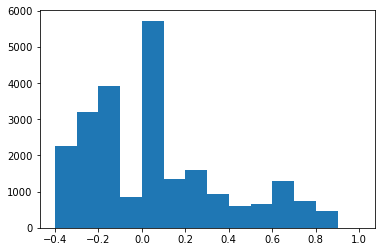

In [135]:
plt.hist(accuracies_corr_lab_exists['Accuracy Difference'], bins=np.arange(-0.4, 1.1, 0.1))
plt.show()

In [136]:
same_accuracy_rate = np.count_nonzero(accuracies_corr_lab_exists['Accuracy Difference'] == 0) / len(accuracies_corr_lab_exists)
same_accuracy_rate

0.19563936358279316

In [137]:
experts_higher_rate = np.count_nonzero(accuracies_corr_lab_exists['Accuracy Difference'] > 0) / len(accuracies_corr_lab_exists)
experts_higher_rate

0.37448438420742486

In [138]:
crowd_higher_rate = np.count_nonzero(accuracies_corr_lab_exists['Accuracy Difference'] < 0) / len(accuracies_corr_lab_exists)
crowd_higher_rate

0.429876252209782

In [139]:
same_accuracy_rate + experts_higher_rate + crowd_higher_rate

1.0

Numbers of interest that arise out of this comparison across all the cases with correct label defined:
    
<strong>Equal accuracy rate:</strong> 19.6% of the time both the crowd and the experts had the same accuracy rate.

<strong>Expert accuracy rate higher:</strong> 37.4% of cases have the expert accuracy rate higher than the crowd's.

<strong>Crowd accuracy rate higher:</strong> 43.0% of cases have the crowd with the higher accuracy rate over the experts.

In these numbers overall, the crowd accuracy rate is <i>at least as good as</i> the expert accuracy rate 62.6% of the time.

### Comparing Subsets of Cases

<h3>Expert Vote Unanimous</h3>

How does the accuracy comparison look specifically on the cases where the experts were unanimous?

In [140]:
experts_unanimous = accuracies_corr_lab_exists[ accuracies_corr_lab_exists['Expert Accuracy'] == 1 ]
experts_unanimous

,Expert Accuracy,Crowd Accuracy,Accuracy Difference
1,1.0,1.0,0.0
2,1.0,1.0,0.0
3,1.0,1.0,0.0
5,1.0,1.0,0.0
6,1.0,1.0,0.0
...,...,...,...
30125,1.0,1.0,0.0
30143,1.0,1.0,0.0
30195,1.0,1.0,0.0
30204,1.0,0.5,0.5


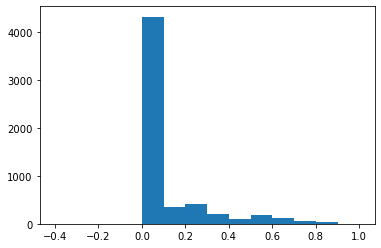

In [141]:
plt.hist(experts_unanimous['Accuracy Difference'], bins=np.arange(-0.4, 1.1, 0.1))
plt.show()

In [142]:
np.count_nonzero(experts_unanimous['Accuracy Difference']) / len(experts_unanimous)

0.2753403933434191

In cases where the experts were unanimous with their labeling, by definition their accuracy is 100%, and so the crowd accuracy can never be higher. But we can look at the difference of accuracy to get a sense of how closely the crowd labeling followed along. 

27.5% of the time in this case, the expert accuracy was higher than that of the crowd, meaning the crowd chose incorrectly. Equivalently, the crowd did choose the correct label 72.5% of the time.

<h3>Slim Majority in Expert Votes</h3>

What about more difficult cases where the experts were as close as possible to a tie? In terms of our expert accuracy rate, this kind of case has the value 5/8.

In [143]:
experts_5_votes = accuracies_corr_lab_exists[ accuracies_corr_lab_exists['Expert Accuracy'] == 5/8 ]
experts_5_votes

,Expert Accuracy,Crowd Accuracy,Accuracy Difference
203,0.625,1.000,-0.375
413,0.625,0.857,-0.232
430,0.625,0.250,0.375
3534,0.625,0.000,0.625
3726,0.625,0.857,-0.232
...,...,...,...
30282,0.625,0.667,-0.042
30286,0.625,1.000,-0.375
30287,0.625,1.000,-0.375
30289,0.625,0.333,0.292


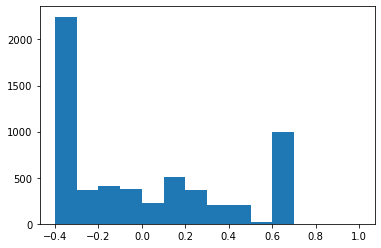

In [144]:
plt.hist(experts_5_votes['Accuracy Difference'], bins=np.arange(-0.4, 1.1, 0.1))
plt.show()

In [145]:
len(experts_5_votes[ experts_5_votes['Accuracy Difference'] < 0 ]) / len(experts_5_votes)

0.5733063700707786

In these slim expert majority cases, the crowd actually outperformed. 57.3% of the time, the crowd accuracy rating was higher than the expert accuracy rating.                 

<h2>Expert Vote Tied, Correct Label Undefined</h2>

By the way the correct label is defined, we simply don't have one in the difficult cases where the expert vote came out tied. But it's still interesting to consider the question of how the crowd votes tended to turn out in these cases. Were they also split? Or, was there a notably higher amount of agreement among the crowd votes?

In [146]:
no_correct_label = results_quant[ results_quant['Expert Yes Votes'] == 4 ]
no_correct_label

,Case ID,Expert Yes Votes,Qualified Reads,Correct Label,Majority Label,Difficulty,Agreement,First Choice Answer,First Choice Votes,First Choice Weight,Second Choice Answer,Second Choice Votes,Second Choice Weight,Expert Accuracy,Crowd Accuracy,Accuracy Difference
4,5888091,4,7,None,yes,NaN,0.571,yes,4,3.28,no,3,2.32,NaN,NaN,NaN
695,5888782,4,5,None,no,NaN,1.000,no,5,3.94,yes,0,0.00,NaN,NaN,NaN
3735,5891822,4,5,None,yes,NaN,0.800,yes,4,3.10,no,1,0.76,NaN,NaN,NaN
3873,5891960,4,7,None,no,NaN,1.000,no,7,5.53,yes,0,0.00,NaN,NaN,NaN
3892,5891979,4,8,None,no,NaN,0.625,no,5,3.92,yes,3,2.38,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
30271,5918358,4,13,None,yes,NaN,0.769,yes,10,7.84,no,3,2.36,NaN,NaN,NaN
30273,5918360,4,5,None,yes,NaN,1.000,yes,5,3.92,no,0,0.00,NaN,NaN,NaN
30276,5918363,4,8,None,yes,NaN,1.000,yes,8,6.26,no,0,0.00,NaN,NaN,NaN
30279,5918366,4,10,None,yes,NaN,0.900,yes,9,7.18,no,1,0.80,NaN,NaN,NaN


We'll take a look at the 'Agreement' values, which represent how close to unanimous the crowd vote was. An 'Agreement' value of 1.000 means the crowd were completely unanimous; at the other end of the range, a value of 0.5 represents an even split in the crowd vote.

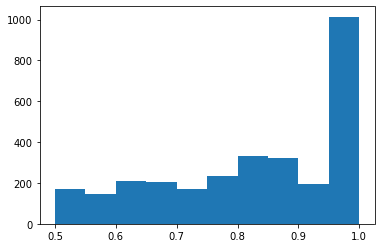

In [147]:
plt.hist(no_correct_label['Agreement'])
plt.show()

In [148]:
np.count_nonzero(no_correct_label['Qualified Reads'] == 1)

4

In [149]:
np.count_nonzero( no_correct_label['Agreement'] == 1 ) / len(no_correct_label)

0.338

In [150]:
np.count_nonzero( no_correct_label['Agreement'] >= 0.75 ) / len(no_correct_label)

0.6993333333333334

In 33.8% of these cases, the crowd vote was unanimous. <i>(This is not accounted for by there being only one qualified read, as that situation occurs in only a negligible amount of the data.)</i>

In 70.0% of these cases, the crowd had a large majority vote, leaning at least 75% in one direction.

From here, we might want to compare back to cases where we do have a defined correct label. How well did the crowd actually do in those cases where they voted with unanimous agreement? Or with a large majority like at least 75%?

In [151]:
corr_label = results_quant[ results_quant['Correct Label'].apply(pd.notna) ]
corr_label

,Case ID,Expert Yes Votes,Qualified Reads,Correct Label,Majority Label,Difficulty,Agreement,First Choice Answer,First Choice Votes,First Choice Weight,Second Choice Answer,Second Choice Votes,Second Choice Weight,Expert Accuracy,Crowd Accuracy,Accuracy Difference
0,5888087,2,2,no,no,0.000,1.000,no,2,1.54,yes,0,0.00,0.750,1.000,-0.250
1,5888088,0,3,no,no,0.000,1.000,no,3,2.34,yes,0,0.00,1.000,1.000,0.000
2,5888089,0,2,no,no,0.000,1.000,no,2,1.70,yes,0,0.00,1.000,1.000,0.000
3,5888090,0,1,no,no,0.000,1.000,no,1,0.82,yes,0,0.00,1.000,1.000,0.000
5,5888092,0,4,no,no,0.000,1.000,no,4,3.30,yes,0,0.00,1.000,1.000,0.000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
30286,5918373,5,1,yes,yes,0.000,1.000,yes,1,0.80,no,0,0.00,0.625,1.000,-0.375
30287,5918374,5,4,yes,yes,0.000,1.000,yes,4,3.18,no,0,0.00,0.625,1.000,-0.375
30288,5918375,2,2,no,yes,1.000,1.000,yes,2,1.56,no,0,0.00,0.750,0.000,0.750
30289,5918376,3,3,no,yes,0.667,0.667,yes,2,1.56,no,1,0.76,0.625,0.333,0.292


In [152]:
high_agreement = corr_label[ corr_label['Agreement'] >= 0.75 ]
high_agreement

,Case ID,Expert Yes Votes,Qualified Reads,Correct Label,Majority Label,Difficulty,Agreement,First Choice Answer,First Choice Votes,First Choice Weight,Second Choice Answer,Second Choice Votes,Second Choice Weight,Expert Accuracy,Crowd Accuracy,Accuracy Difference
0,5888087,2,2,no,no,0.0,1.0,no,2,1.54,yes,0,0.00,0.750,1.0,-0.250
1,5888088,0,3,no,no,0.0,1.0,no,3,2.34,yes,0,0.00,1.000,1.0,0.000
2,5888089,0,2,no,no,0.0,1.0,no,2,1.70,yes,0,0.00,1.000,1.0,0.000
3,5888090,0,1,no,no,0.0,1.0,no,1,0.82,yes,0,0.00,1.000,1.0,0.000
5,5888092,0,4,no,no,0.0,1.0,no,4,3.30,yes,0,0.00,1.000,1.0,0.000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
30285,5918372,6,7,yes,yes,0.0,1.0,yes,7,5.78,no,0,0.00,0.750,1.0,-0.250
30286,5918373,5,1,yes,yes,0.0,1.0,yes,1,0.80,no,0,0.00,0.625,1.0,-0.375
30287,5918374,5,4,yes,yes,0.0,1.0,yes,4,3.18,no,0,0.00,0.625,1.0,-0.375
30288,5918375,2,2,no,yes,1.0,1.0,yes,2,1.56,no,0,0.00,0.750,0.0,0.750


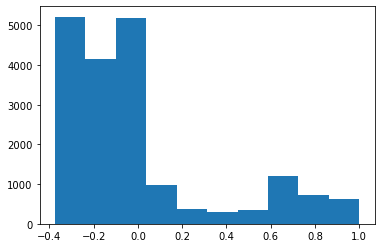

In [153]:
plt.hist(high_agreement['Accuracy Difference'])
plt.show()

In [154]:
np.count_nonzero(high_agreement['Accuracy Difference'] < 0) / len(high_agreement)

0.5143499398818547

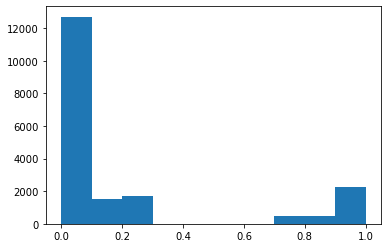

In [155]:
plt.hist(high_agreement['Difficulty'])
plt.show()

In [156]:
1 - (np.count_nonzero(high_agreement['Difficulty'] > 0)) / len(high_agreement)

0.6610382142297035

When the crowd voted with at least a 75% majority, in cases with a correct label defined: 

- they chose the correct label 64.0% of the time
- their accuracy rating was higher than the experts 51.4% of the time

In [157]:
crowd_unanimous = high_agreement[ high_agreement['Agreement'] == 1 ]
crowd_unanimous

,Case ID,Expert Yes Votes,Qualified Reads,Correct Label,Majority Label,Difficulty,Agreement,First Choice Answer,First Choice Votes,First Choice Weight,Second Choice Answer,Second Choice Votes,Second Choice Weight,Expert Accuracy,Crowd Accuracy,Accuracy Difference
0,5888087,2,2,no,no,0.0,1.0,no,2,1.54,yes,0,0.0,0.750,1.0,-0.250
1,5888088,0,3,no,no,0.0,1.0,no,3,2.34,yes,0,0.0,1.000,1.0,0.000
2,5888089,0,2,no,no,0.0,1.0,no,2,1.70,yes,0,0.0,1.000,1.0,0.000
3,5888090,0,1,no,no,0.0,1.0,no,1,0.82,yes,0,0.0,1.000,1.0,0.000
5,5888092,0,4,no,no,0.0,1.0,no,4,3.30,yes,0,0.0,1.000,1.0,0.000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
30281,5918368,5,8,yes,yes,0.0,1.0,yes,8,6.50,no,0,0.0,0.625,1.0,-0.375
30285,5918372,6,7,yes,yes,0.0,1.0,yes,7,5.78,no,0,0.0,0.750,1.0,-0.250
30286,5918373,5,1,yes,yes,0.0,1.0,yes,1,0.80,no,0,0.0,0.625,1.0,-0.375
30287,5918374,5,4,yes,yes,0.0,1.0,yes,4,3.18,no,0,0.0,0.625,1.0,-0.375


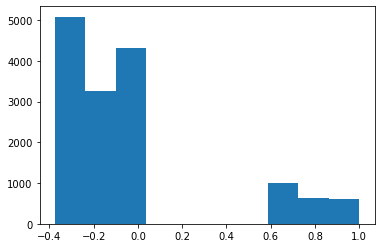

In [158]:
plt.hist(crowd_unanimous['Accuracy Difference'])
plt.show()

In [159]:
np.count_nonzero(crowd_unanimous['Difficulty'] == 0) / len(crowd_unanimous)

0.8491136180499597

In [160]:
np.count_nonzero(crowd_unanimous['Accuracy Difference'] < 0) / len(crowd_unanimous)

0.5596293311845286

When the crowd voted unanimously, in cases with a correct label defined:

- they chose the correct label 84.9% of the time
- crowd accuracy was higher than expert accuracy 56.0% of the time

---

<h2>Comparison Conclusions</h2>

As we saw in a first pass at the comparison of accuracy rates, the crowd accuracy rating in this data is overall <i>at least as good</i> as the expert accuracy rating in 62.5% of cases.

In considering some specific sub-sets of cases, the crowd accuracy rating has been more likely than not to be higher than the expert accuracy rating in each sub-set we've considered where that is possible. The exception is the case where the expert vote was unanimous, and by definition we consider expert accuracy to be 100%.

<strong>This suggests, in general, that the crowd aggregate opinion could be worth taking seriously. Also, if that idea is justified, then it can be extended to cases where the expert vote was deadlocked.</strong>